In [135]:
import pandas as pd
import numpy as np
import random
data=pd.read_csv("FAOLEX_ALL.csv")
print(data.keys())
np.random.seed(69)
random.seed(69)

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [117]:
# remve repealed legislation
data["Repealed"].fillna(value = "N", inplace=True)
data["Repealed"] = pd.Categorical(data["Repealed"])
data=data[data["Repealed"]=="N"]


In [118]:
#data = data[data["Type of text"]=="Legislation"]

In [119]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1




In [120]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])




In [121]:
# Ignore
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [122]:
print(keywords[15])
print(stemmed_words[15])


['maritime zone', ' EEZ-Exclusive Economic Zone', ' continental shelf']
['maritime zon', ' eez-exclusive economic zon', ' continental shelf']


# Top2vec topic model

In [141]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


2023-06-13 17:28:05,939 - top2vec - INFO - Pre-processing documents for training
Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x0000011E94F7C670>
Traceback (most recent call last):
  File "C:\Users\Jacob pc\anaconda3\lib\weakref.py", line 104, in remove
KeyboardInterrupt: 


KeyboardInterrupt: 

In [137]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1125, 1065, 1059, ...,   20,   19,   17], dtype=int64)

In [140]:
model.get_num_topics()

1040

In [136]:
topic_words,word_scores,topic_nums = model.get_topics(5)

In [138]:
#save the model
#model.save("top2vec model")

#to load the data
#model = Top2Vec.load("top2vec model")

In [128]:
# Find documents most similar to a specific topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 133668, Score: 0.98247891664505
-----------
governance local government institution
-----------

Document: 135137, Score: 0.981825590133667
-----------
local government governance
-----------

Document: 134985, Score: 0.9814186692237854
-----------
local government governance institution
-----------

Document: 123045, Score: 0.9787275791168213
-----------
land-use planning institution local government institution local government
-----------

Document: 128507, Score: 0.9784504175186157
-----------
governance local government institution
-----------

Document: 149022, Score: 0.9770303964614868
-----------
local government governance
-----------

Document: 147744, Score: 0.9756966829299927
-----------
governance local government
-----------

Document: 119340, Score: 0.9755572080612183
-----------
institution local government
-----------

Document: 135933, Score: 0.9744855165481567
-----------
local government sustainable development institution local government sustainable deve

In [139]:
# Check documents
data.iloc[370]


KeyboardInterrupt



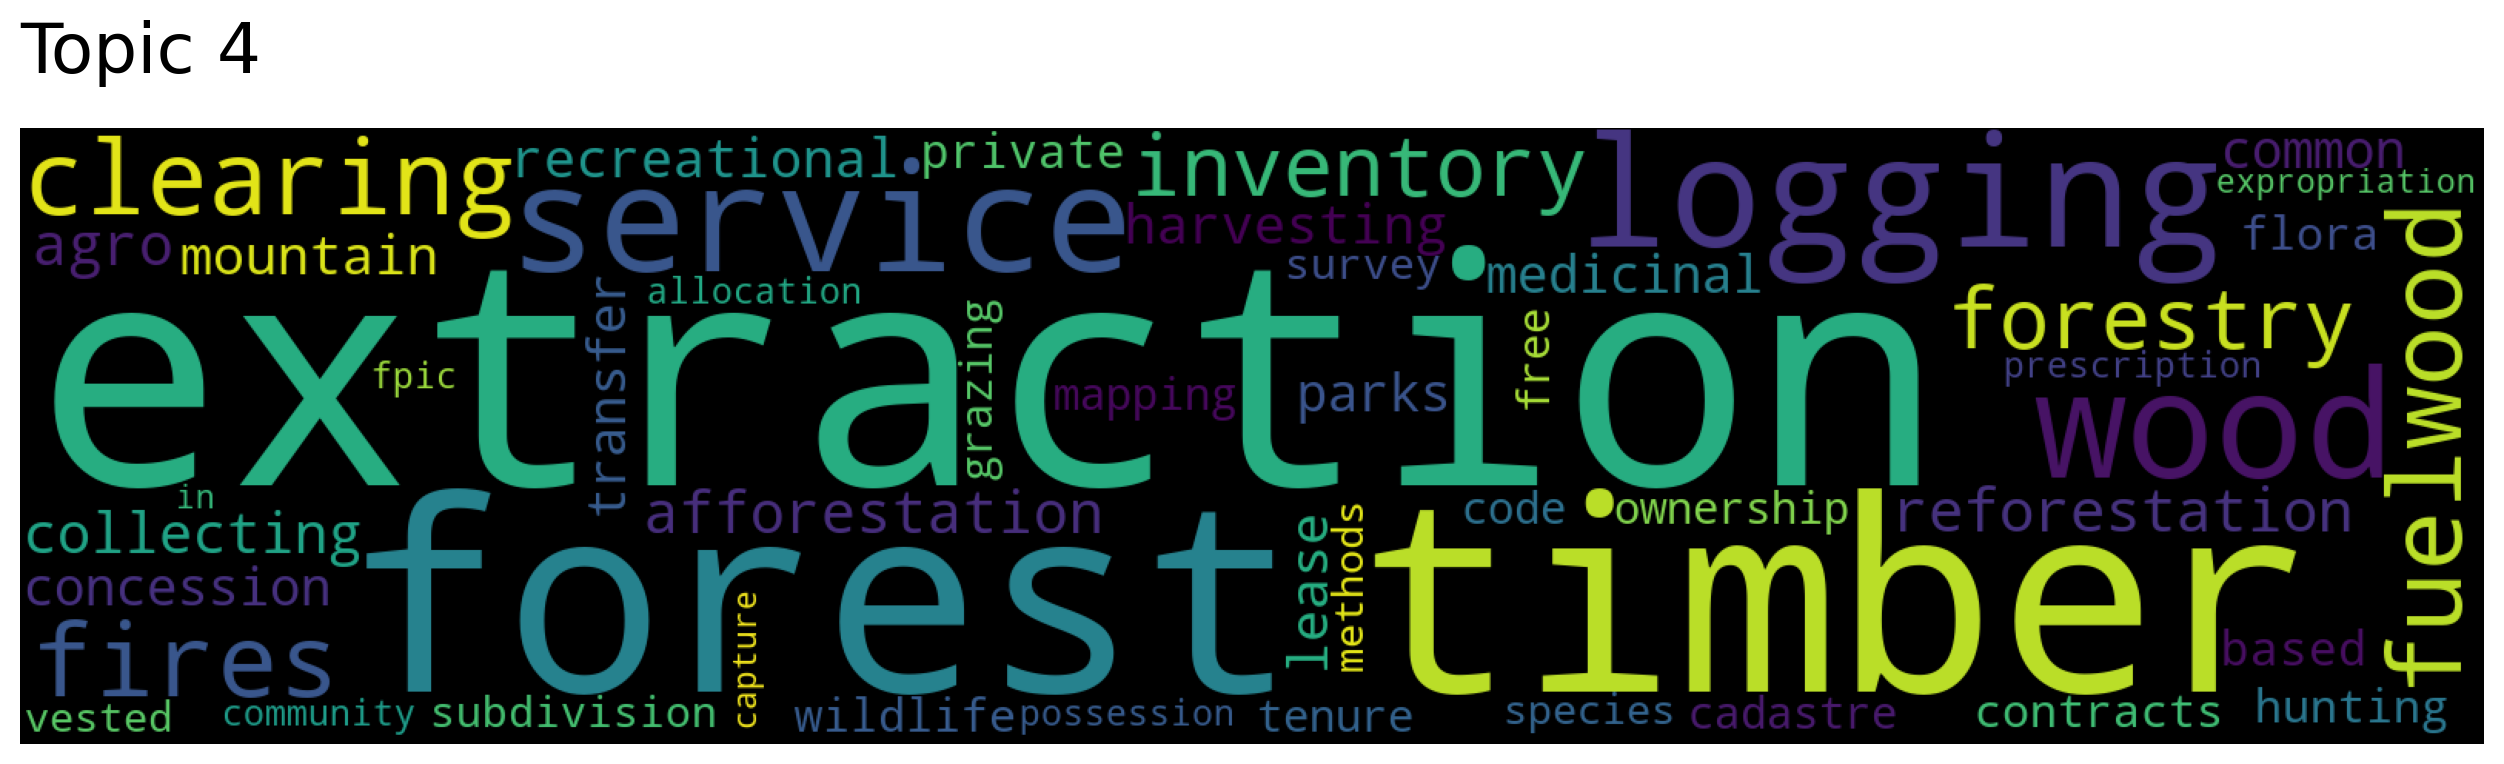

In [130]:
model.generate_topic_wordcloud(4,reduced=False)

In [131]:
# Look up topics corresponding to a keyword
#topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["waste"], num_topics=10)
#print(topic_words)
#print(topic_nums)
#print(topic_scores)

#Topic reduction

In [132]:
# Reduce number of topics to n
n=75
topic_mapping = model.hierarchical_topic_reduction(num_topics=n)


KeyboardInterrupt: 

In [ ]:
# Reduce number of countries
reduced=False

In [ ]:
model.get_num_topics(reduced=True)
#print(model.topic_words_reduced)

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [ ]:
# Compute uniqe countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [ ]:
#View all countries
#set(country_new)

In [ ]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1


In [ ]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)
country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num],reduced=reduced)
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [ ]:

 
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

#Standardisering
#for i in range(len(countries)):
 #   country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i]) 


In [ ]:
def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(country_new,"correlation")
np.shape(country_co_occurrence)

In [ ]:
#Remove small islands

for i in range(len(set(country_new))):
    if country_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country Network

In [ ]:
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt
countries_swap_copy = countries_swap.copy()

G = nx.Graph()

size = country_co_occurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])
# Remove small isalnds
for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(20, 20))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [ ]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.1,seed=69)
unique_coms = np.unique(list(comms))

In [ ]:
community_assignment = {}

# Assign community indices to nodes


# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
plt.show()


In [ ]:
from networkx.algorithms.community import louvain_communities
resolution=[0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
scores=np.zeros(len(resolution))
j=0
for res in resolution:
    comms = louvain_communities(G,weight="weight",resolution=res,seed=69)
    unique_coms = np.unique(list(comms))
    i=1
    communities={}
    for community in comms:
        #print("c",i)
        com_countries = []
        for c in community:
            #print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1
    for com in communities.values():
        if len(com)==1:
            scores[j]+=1
        elif len(com)>=30:
            scores[j]+=len(com)-29
    j+=1

In [ ]:
res_op=np.argmin(scores)
comms = louvain_communities(G,weight="weight",resolution=resolution[res_op],seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1



for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

In [ ]:
# compute similartiy between countries:
#WIP
c1 = ["Pakistan","India"]
print(country_topic_matrix[countries["Pakistan"],:])
print(country_topic_matrix[countries["India"],:])
print(country_co_occurrence[countries["Pakistan"],countries["India"]])
for i in range(250):
    if country_co_occurrence[countries["Pakistan"],i] >=0.3:
        print(i,country_co_occurrence[countries["Pakistan"],i])

In [ ]:
countries_swap[249]

## Compare communities to income

In [ ]:
import pandas as pd
#country data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

In [ ]:

income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])


In [ ]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

In [ ]:

for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [ ]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',1),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]


for i,j in extra_countries:
    countries_income_dic[countries[i]]= j


In [ ]:
# Compare countries income: function takes a list of country indexes and returns the rang between lowest and higest income country and the standard deviation
def check_income(community):
    com_income = []
    for i in community:
        com_income.append(countries_income_dic[i])
    range = max(com_income)-min(com_income)
    std = np.std(com_income)
    return range, std
    

    

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            h=2
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Low income")
pop_b = mpatches.Patch(color='#7a5195', label="Lower middle income")
pop_c = mpatches.Patch(color='#ef5675', label="Upper middle income")
pop_d = mpatches.Patch(color='#ffa600', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])



In [ ]:
for c in communities[32]:
    print(countries_swap[c],countries_income_dic[c])

In [ ]:
print("Number of countries in different income groups + proportion")
print("Low: ",income_groups.count("Low income"),income_groups.count("Low income")/len(income_groups))
low_p = income_groups.count("Low income")/len(income_groups)
print("Lower middle: ",income_groups.count("Lower middle income"),income_groups.count("Lower middle income")/len(income_groups))
lowermiddle_p = income_groups.count("Lower middle income")/len(income_groups)
print("Upper middle: ",income_groups.count("Upper middle income"),income_groups.count("Upper middle income")/len(income_groups))
uppermiddle_p = income_groups.count("Upper middle income")/len(income_groups)
print("High: ",income_groups.count("High income"),income_groups.count("High income")/len(income_groups))
high_p = income_groups.count("High income")/len(income_groups)

In [ ]:
# Make permutation test
observed_income =[]
observed_community = []
for i in range(len(communities)):
     for c in communities[i+1]:
        observed_income.append(countries_income_dic[c])
        observed_community.append(i+1)
# Dsitribtuion prior to permutation (proportion of high income)
def count_community_3(communities, numbers):
    count_array = np.zeros(len(communities))  # Dictionary to store the count of each community
    community_count = np.zeros(len(communities))
    # Iterate over the communities and numbers lists
    for community, number in zip(communities, numbers):
        if number == 3:
            count_array[community-1]+=1
        community_count[community-1]+=1
    return count_array,community_count

og_scores = []
prop_high,community_count=count_community_3(observed_community,observed_income)
for community, count, total_count in zip(communities,prop_high,community_count):
    #print(f"Community {community} has {count/total_count} % of high income.")
    og_scores.append(count/total_count)




In [ ]:
import random
permuted_scores=[]
prop_high,community_count=count_community_3(observed_community,observed_income)
for community, count, total_count in zip(communities,prop_high,community_count):
    #print(f"Community {community} has {count/total_count} % of high income.")
    permuted_scores.append(count/total_count)




In [ ]:
a=observed_community
a

# Governance

In [ ]:
#country governance data
governance = pd.read_excel("governence data update.xlsx")
print(governance.keys())
governance_country = []
categorized_governance = []

for est,c in zip(governance["Estimate"],governance["Country/Territory"]):
    if est >=1:
        categorized_governance.append(3)
        governance_country.append(c)
    elif est>=0 and est<1:
        categorized_governance.append(2)
        governance_country.append(c)
    elif est>-1 and est<0:
        categorized_governance.append(1)
        governance_country.append(c)
    elif est<=-1:
        categorized_governance.append(0)
        governance_country.append(c)
        

In [ ]:
#income_countries = list(income["Economy"])
#income_groups = list(income["Income group"])
governance_listed_countries =[]
governance_dic={}
for i in range(len(governance_country)):
    for j in range(len(countries_swap)):
        if governance_country[i] == countries_swap[j]:
            governance_listed_countries.append(j)
            governance_dic[j]=categorized_governance[i]
missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_listed_countries:
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [ ]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_gov_countries_names:
    best_match = process.extractOne(country1, governance_country)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

In [ ]:
for i,j in matches:
    governance_dic[countries[i]]=categorized_governance[governance_country.index(j)]

missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_dic.keys():
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [ ]:
# Extra countries, 5 = Nan
extra_countries = [('Saint Barthélemy (FRA)',5),("Isle of Man (UK)",5),('Kyrgyzstan',1),('Andean Community',5),('Palestine',0),('Iran (Islamic Republic of)',0),('Slovakia',2),("Curaçao",5),('Saint Helena, Ascension and Tristan da Cunha (UK)',5),('Jersey  (UK)',3),('Montserrat (UK)',3),("Bermuda (UK)",5),("Cabo Verde",5),('European Union',5),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',5),
('Anguilla (UK)',5),('Cook Islands',3),('Micronesia (Federated States of)',3),('Republic of Korea',2),("Northern Mariana Islands (USA)",3),('MERCOSUR',5),("British Virgin Islands (UK)",5),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',0),('Pitcairn (UK)',3),("Lao People's Democratic Republic",0),("Turks and Caicos Islands (UK)",5),("Gibraltar (UK)",5),
("Taiwan Province of China",3),("South Georgia and the South Sandwich Islands (UK)",5)]


for i,j in extra_countries:
    governance_dic[countries[i]]= j


In [ ]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 2, color="#808080",width=0.8,edgecolor="#000000")
            h=2
        else:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 2, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Weak Government Effectiveness")
pop_b = mpatches.Patch(color='#7a5195', label="Lower Middle Government Effectiveness")
pop_c = mpatches.Patch(color='#ef5675', label="Upper Middle Government Effectiveness")
pop_d = mpatches.Patch(color='#ffa600', label='Strong Government Effectiveness')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])

In [ ]:
print("Number of countries in different government effectiveness classes + proportion")
low_p = list(governance_dic.values()).count(0)/len(income_groups)
print("Low: ",list(governance_dic.values()).count(0),low_p)
lowermiddle_p = list(governance_dic.values()).count(1)/len(income_groups)
print("Lower middle: ",list(governance_dic.values()).count(1),lowermiddle_p)
uppermiddle_p = list(governance_dic.values()).count(2)/len(income_groups)
print("Upper middle: ",list(governance_dic.values()).count(2),uppermiddle_p)
high_p = list(governance_dic.values()).count(3)/len(income_groups)
print("High: ",list(governance_dic.values()).count(3),high_p)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

#combine the data points
data_points_dic = {}

for i in governance_dic:
    data_points_dic[i] = [governance_dic[i], countries_income_dic[i]]

lda = LinearDiscriminantAnalysis()

c_assign = []
for i in range(500):
    if i in community_assignment:
        c_assign.append(community_assignment[i])

X = []
for i in range(500):
    if i in data_points_dic:
        X.append(data_points_dic[i])

X2 = []
for i in range(500):
    if i in community_assignment:
        X2.append(X[i])

X2 = np.array(X2)
c_assign = np.array(c_assign)



In [ ]:
lda.fit(X2,c_assign)
predicts = lda.predict(X2)
accuracy = accuracy_score(c_assign,predicts)
print("Accuracy:", accuracy)